In [ ]:
!pip install gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!gdown https://drive.google.com/uc?id=1Sp9sq1W3geHwaj0wvx1uFofD67nIjrPq

Downloading...
From: https://drive.google.com/uc?id=1Sp9sq1W3geHwaj0wvx1uFofD67nIjrPq
To: /content/data.zip
100% 40.2M/40.2M [00:00<00:00, 173MB/s]


In [ ]:
!unzip /content/data.zip

Archive:  /content/data.zip
   creating: data/
   creating: data/invasive/
  inflating: data/invasive/100.jpg   
  inflating: data/invasive/1000.jpg  
  inflating: data/invasive/1002.jpg  
  inflating: data/invasive/1003.jpg  
  inflating: data/invasive/1004.jpg  
  inflating: data/invasive/1005.jpg  
  inflating: data/invasive/1008.jpg  
  inflating: data/invasive/1009.jpg  
  inflating: data/invasive/101.jpg   
  inflating: data/invasive/1010.jpg  
  inflating: data/invasive/1011.jpg  
  inflating: data/invasive/1016.jpg  
  inflating: data/invasive/1019.jpg  
  inflating: data/invasive/102.jpg   
  inflating: data/invasive/1022.jpg  
  inflating: data/invasive/1026.jpg  
  inflating: data/invasive/1028.jpg  
  inflating: data/invasive/103.jpg   
  inflating: data/invasive/1030.jpg  
  inflating: data/invasive/1033.jpg  
  inflating: data/invasive/1035.jpg  
  inflating: data/invasive/1036.jpg  
  inflating: data/invasive/1039.jpg  
  inflating: data/invasive/104.jpg   
  inflating: 

In [ ]:
!pip install jcopdl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for jcopdl: filename=jcopdl-1.1.9-py2.py3-none-any.whl size=16924 sha256=8c09ef0a2fd47b4d97c15258249cdca95af61ce205c7aaae3395ff441d1ee1d2
  Stored in directory: /root/.cache/pip/wheels/e5/78/9d/931694cba38491e16f1a94719193211fd12a7307570d9bb562
Successfully built jcopdl


In [ ]:
import jcopdl
jcopdl.__version__

'1.1.9'

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Dataset & Cross Validation

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, ConcatDataset, SubsetRandomSampler
from sklearn.model_selection import KFold

In [ ]:
bs = 128
crop_size = 64

transform = transforms.Compose([
    transforms.RandomResizedCrop(crop_size, scale=(0.8, 1.0)),
    transforms.ToTensor()
])
dataset = datasets.ImageFolder("data", transform=transform)


In [ ]:
k = 5
splits = KFold(n_splits=k, shuffle=True)
foldperf={}

In [ ]:
label2cat = dataset.classes
label2cat

['invasive', 'noninvasive']

# Arsitektur & Config

In [ ]:
from jcopdl.layers import conv_block, linear_block

In [ ]:
# Kalau manual tanpa block

# nn.Conv2d(2, 8, 3, 1, 1),
# nn.ReLU(),
# nn.MaxPool2d(2,2) 

In [ ]:
class MyCNN (nn.Module):
    def __init__(self) :
        super().__init__()
        self.conv = nn.Sequential(
            conv_block(3, 8),
            conv_block(8, 16),
            conv_block(16, 32),
            conv_block(32, 64),
            nn.Flatten()
        )  
        self.fc = nn.Sequential(
            linear_block(1024, 256, dropout=0.1),
            linear_block(256, 2, activation='lsoftmax')
        )    
        
    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x


In [ ]:
config = set_config({
    "batch_size" : bs,
    "crop_size" : crop_size
})

## Training Preparation -> MCOC

In [ ]:
model = MyCNN().to(device)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, save_every=1, outdir="model")

## Training

In [ ]:
from tqdm.auto import tqdm

def train_epoch(dataloader, model, criterion, optimizer, device):
    train_cost,train_correct = 0.0,0
    model.train()
    for feature, target in tqdm(dataloader, desc="Train"):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_cost += loss.item() * feature.shape[0]
        train_correct += (output.argmax(1) == target).sum().item()
    return train_cost,train_correct

def valid_epoch(dataloader, model, criterion, device):
    valid_cost,valid_correct = 0.0,0
    model.eval()
    for feature, target in tqdm(dataloader, desc="Test"):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)
        valid_cost += loss.item() * feature.shape[0]
        valid_correct += (output.argmax(1) == target).sum().item()
    return valid_cost,valid_correct

In [ ]:
for fold, (train_idx, val_idx) in enumerate(splits.split(np.arange(len(dataset)))):
    print('Fold {}'.format(fold+1))

    trainsampler = SubsetRandomSampler(train_idx)
    testsampler = SubsetRandomSampler(val_idx)
    trainloader = DataLoader(dataset, batch_size=bs, sampler=trainsampler)
    testloader = DataLoader(dataset, batch_size=bs, sampler=testsampler)

    history = {'train_cost':[], 'test_cost':[], 'train_score':[], 'test_score':[]}
    epochs = 10
    for epoch in range (epochs):
        train_cost, train_score = train_epoch(trainloader, model, criterion, optimizer, device)
        with torch.no_grad():
             test_cost, test_score = valid_epoch(testloader, model, criterion, device)
        
        train_cost = train_cost / len(trainloader.sampler)
        train_score = train_score / len(trainloader.sampler) * 100
        test_cost = test_cost / len(testloader.sampler)
        test_score = test_score / len(testloader.sampler) * 100
        print("Epoch:{}/{} AVG Training_Cost:{:.3f} AVG Test_Cost:{:.3f} AVG Training_Score {:.2f} % AVG Test_Score {:.2f} %".format(epoch + 1,
                                                                                                                                     epochs,
                                                                                                                                     train_cost,
                                                                                                                                     test_cost,
                                                                                                                                     train_score,
                                                                                                                                     test_score))

        history['train_cost'].append(train_cost)
        history['test_cost'].append(test_cost)
        history['train_score'].append(train_score)
        history['test_score'].append(test_score)

        # Checkpoint
        callback.save_checkpoint()

    foldperf['fold{}'.format(fold+1)] = history

Fold 1


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch:1/10 AVG Training_Cost:0.689 AVG Test_Cost:0.677 AVG Training_Score 56.61 % AVG Test_Score 49.64 %


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch:2/10 AVG Training_Cost:0.647 AVG Test_Cost:0.566 AVG Training_Score 63.39 % AVG Test_Score 76.43 %


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch:3/10 AVG Training_Cost:0.582 AVG Test_Cost:0.550 AVG Training_Score 70.09 % AVG Test_Score 72.50 %


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch:4/10 AVG Training_Cost:0.554 AVG Test_Cost:0.467 AVG Training_Score 72.77 % AVG Test_Score 80.00 %


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch:5/10 AVG Training_Cost:0.483 AVG Test_Cost:0.429 AVG Training_Score 77.23 % AVG Test_Score 82.50 %


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch:6/10 AVG Training_Cost:0.462 AVG Test_Cost:0.391 AVG Training_Score 78.57 % AVG Test_Score 82.86 %


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch:7/10 AVG Training_Cost:0.417 AVG Test_Cost:0.371 AVG Training_Score 81.96 % AVG Test_Score 82.86 %


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch:8/10 AVG Training_Cost:0.401 AVG Test_Cost:0.358 AVG Training_Score 81.88 % AVG Test_Score 84.64 %


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch:9/10 AVG Training_Cost:0.438 AVG Test_Cost:0.342 AVG Training_Score 80.62 % AVG Test_Score 87.86 %


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch:10/10 AVG Training_Cost:0.386 AVG Test_Cost:0.345 AVG Training_Score 82.50 % AVG Test_Score 85.71 %
Fold 2


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch:1/10 AVG Training_Cost:0.357 AVG Test_Cost:0.445 AVG Training_Score 85.98 % AVG Test_Score 80.36 %


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch:2/10 AVG Training_Cost:0.371 AVG Test_Cost:0.430 AVG Training_Score 84.20 % AVG Test_Score 81.43 %


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch:3/10 AVG Training_Cost:0.379 AVG Test_Cost:0.432 AVG Training_Score 83.04 % AVG Test_Score 80.00 %


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch:4/10 AVG Training_Cost:0.348 AVG Test_Cost:0.427 AVG Training_Score 85.45 % AVG Test_Score 81.43 %


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch:5/10 AVG Training_Cost:0.324 AVG Test_Cost:0.409 AVG Training_Score 86.07 % AVG Test_Score 82.50 %


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch:6/10 AVG Training_Cost:0.318 AVG Test_Cost:0.416 AVG Training_Score 86.25 % AVG Test_Score 81.07 %


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch:7/10 AVG Training_Cost:0.329 AVG Test_Cost:0.455 AVG Training_Score 86.88 % AVG Test_Score 80.00 %


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch:8/10 AVG Training_Cost:0.321 AVG Test_Cost:0.385 AVG Training_Score 86.61 % AVG Test_Score 83.93 %


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch:9/10 AVG Training_Cost:0.290 AVG Test_Cost:0.406 AVG Training_Score 88.66 % AVG Test_Score 82.86 %


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch:10/10 AVG Training_Cost:0.278 AVG Test_Cost:0.392 AVG Training_Score 88.48 % AVG Test_Score 84.29 %
Fold 3


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch:1/10 AVG Training_Cost:0.319 AVG Test_Cost:0.281 AVG Training_Score 87.05 % AVG Test_Score 88.93 %


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch:2/10 AVG Training_Cost:0.308 AVG Test_Cost:0.347 AVG Training_Score 88.04 % AVG Test_Score 85.36 %


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch:3/10 AVG Training_Cost:0.314 AVG Test_Cost:0.340 AVG Training_Score 86.88 % AVG Test_Score 85.00 %


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch:4/10 AVG Training_Cost:0.304 AVG Test_Cost:0.308 AVG Training_Score 87.14 % AVG Test_Score 86.43 %


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch:5/10 AVG Training_Cost:0.281 AVG Test_Cost:0.296 AVG Training_Score 88.66 % AVG Test_Score 87.86 %


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch:6/10 AVG Training_Cost:0.275 AVG Test_Cost:0.298 AVG Training_Score 89.55 % AVG Test_Score 87.14 %


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch:7/10 AVG Training_Cost:0.275 AVG Test_Cost:0.302 AVG Training_Score 88.57 % AVG Test_Score 87.14 %


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch:8/10 AVG Training_Cost:0.279 AVG Test_Cost:0.273 AVG Training_Score 89.11 % AVG Test_Score 88.57 %


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch:9/10 AVG Training_Cost:0.262 AVG Test_Cost:0.297 AVG Training_Score 89.11 % AVG Test_Score 87.86 %


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch:10/10 AVG Training_Cost:0.245 AVG Test_Cost:0.280 AVG Training_Score 90.98 % AVG Test_Score 88.21 %
Fold 4


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch:1/10 AVG Training_Cost:0.255 AVG Test_Cost:0.257 AVG Training_Score 90.36 % AVG Test_Score 88.93 %


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch:2/10 AVG Training_Cost:0.242 AVG Test_Cost:0.233 AVG Training_Score 90.27 % AVG Test_Score 91.07 %


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch:3/10 AVG Training_Cost:0.238 AVG Test_Cost:0.293 AVG Training_Score 91.07 % AVG Test_Score 85.36 %


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch:4/10 AVG Training_Cost:0.235 AVG Test_Cost:0.234 AVG Training_Score 90.27 % AVG Test_Score 91.07 %


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch:5/10 AVG Training_Cost:0.237 AVG Test_Cost:0.244 AVG Training_Score 90.89 % AVG Test_Score 88.93 %


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch:6/10 AVG Training_Cost:0.226 AVG Test_Cost:0.235 AVG Training_Score 91.43 % AVG Test_Score 90.71 %


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch:7/10 AVG Training_Cost:0.228 AVG Test_Cost:0.283 AVG Training_Score 91.34 % AVG Test_Score 87.50 %


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch:8/10 AVG Training_Cost:0.225 AVG Test_Cost:0.239 AVG Training_Score 90.71 % AVG Test_Score 91.07 %


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch:9/10 AVG Training_Cost:0.218 AVG Test_Cost:0.269 AVG Training_Score 92.14 % AVG Test_Score 87.86 %


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch:10/10 AVG Training_Cost:0.212 AVG Test_Cost:0.231 AVG Training_Score 91.96 % AVG Test_Score 90.36 %
Fold 5


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch:1/10 AVG Training_Cost:0.230 AVG Test_Cost:0.134 AVG Training_Score 90.89 % AVG Test_Score 95.71 %


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch:2/10 AVG Training_Cost:0.222 AVG Test_Cost:0.165 AVG Training_Score 91.43 % AVG Test_Score 95.00 %


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch:3/10 AVG Training_Cost:0.229 AVG Test_Cost:0.160 AVG Training_Score 91.16 % AVG Test_Score 93.93 %


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch:4/10 AVG Training_Cost:0.219 AVG Test_Cost:0.167 AVG Training_Score 91.88 % AVG Test_Score 94.29 %


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch:5/10 AVG Training_Cost:0.223 AVG Test_Cost:0.189 AVG Training_Score 91.61 % AVG Test_Score 92.86 %


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch:6/10 AVG Training_Cost:0.208 AVG Test_Cost:0.210 AVG Training_Score 91.79 % AVG Test_Score 91.79 %


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch:7/10 AVG Training_Cost:0.205 AVG Test_Cost:0.170 AVG Training_Score 92.23 % AVG Test_Score 92.50 %


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch:8/10 AVG Training_Cost:0.215 AVG Test_Cost:0.140 AVG Training_Score 91.79 % AVG Test_Score 94.29 %


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch:9/10 AVG Training_Cost:0.202 AVG Test_Cost:0.145 AVG Training_Score 91.52 % AVG Test_Score 95.00 %


Train:   0%|          | 0/9 [00:00<?, ?it/s]

Test:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch:10/10 AVG Training_Cost:0.199 AVG Test_Cost:0.170 AVG Training_Score 92.23 % AVG Test_Score 92.86 %


# Analysis

## Performance K-Fold CV

In [ ]:
trc_f, tsc_f, trs_f, tss_f=[],[],[],[]
k=5
for f in range(1,k+1):
     trc_f.append(np.mean(foldperf['fold{}'.format(f)]['train_cost']))
     tsc_f.append(np.mean(foldperf['fold{}'.format(f)]['test_cost']))

     trs_f.append(np.mean(foldperf['fold{}'.format(f)]['train_score']))
     tss_f.append(np.mean(foldperf['fold{}'.format(f)]['test_score']))

print('Performance of {} fold cross validation'.format(k))
print("Average Training Cost: {:.3f} \t Average Test Cost: {:.3f} \t Average Training Score: {:.2f} \t Average Test Score: {:.2f}".format(np.mean(trc_f),np.mean(tsc_f),np.mean(trs_f),np.mean(tss_f)))

Performance of 5 fold cross validation
Average Training Cost: 0.314 	 Average Test Cost: 0.318 	 Average Training Score: 86.39 	 Average Test Score: 86.13


## plot epoch of kfold

In [ ]:
trc1=(foldperf['fold1']['train_cost'])
trc2=(foldperf['fold2']['train_cost'])
trc3=(foldperf['fold3']['train_cost'])
trc4=(foldperf['fold4']['train_cost'])
trc5=(foldperf['fold5']['train_cost'])

tsc1=(foldperf['fold1']['test_cost'])
tsc2=(foldperf['fold2']['test_cost'])
tsc3=(foldperf['fold3']['test_cost'])
tsc4=(foldperf['fold4']['test_cost'])
tsc5=(foldperf['fold5']['test_cost'])
trs1=(foldperf['fold1']['train_score'])
trs2=(foldperf['fold2']['train_score'])
trs3=(foldperf['fold3']['train_score'])
trs4=(foldperf['fold4']['train_score'])
trs5=(foldperf['fold5']['train_score'])

tss1=(foldperf['fold1']['test_score'])
tss2=(foldperf['fold2']['test_score'])
tss3=(foldperf['fold3']['test_score'])
tss4=(foldperf['fold4']['test_score'])
tss5=(foldperf['fold5']['test_score'])



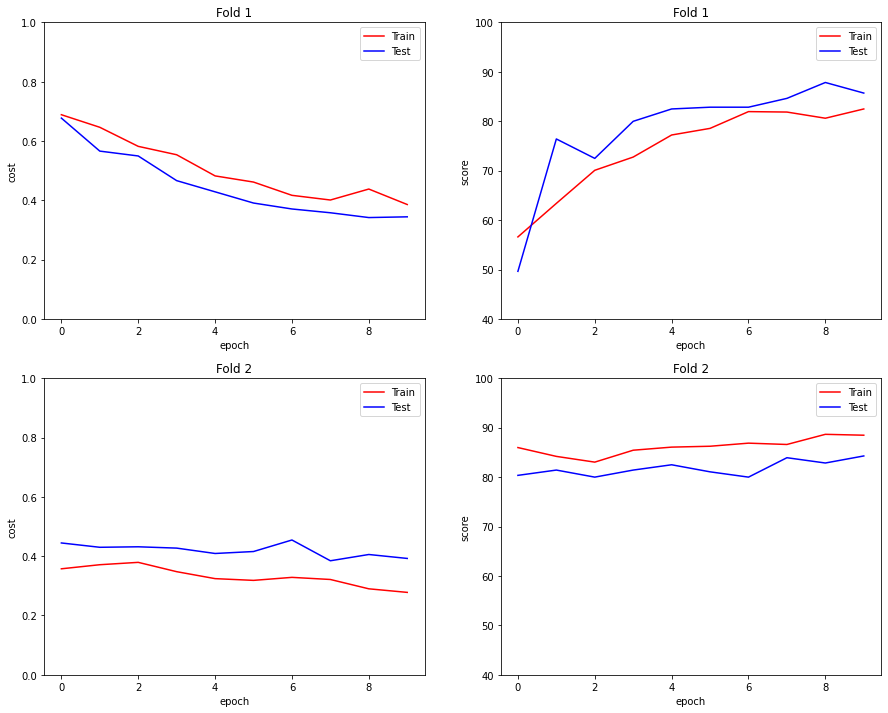

In [ ]:
plt.figure(figsize=(15, 12))

plt.subplot(221)
plt.title('Fold 1')
plt.plot(trc1, 'r-', label="Train")
plt.plot(tsc1, 'b-', label="Test")
plt.xlabel("epoch"); plt.ylabel("cost"); plt.ylim((0,1)); plt.legend();

plt.subplot(222)
plt.title('Fold 1')
plt.plot(trs1, 'r-', label="Train")
plt.plot(tss1, 'b-', label="Test")
plt.xlabel("epoch"); plt.ylabel("score"); plt.ylim((40,100)); plt.legend();

plt.subplot(223)
plt.title('Fold 2')
plt.plot(trc2, 'r-', label="Train")
plt.plot(tsc2, 'b-', label="Test")
plt.xlabel("epoch"); plt.ylabel("cost"); plt.ylim((0,1)); plt.legend();

plt.subplot(224)
plt.title('Fold 2')
plt.plot(trs2, 'r-', label="Train")
plt.plot(tss2, 'b-', label="Test")
plt.xlabel("epoch"); plt.ylabel("score"); plt.ylim((40,100)); plt.legend();



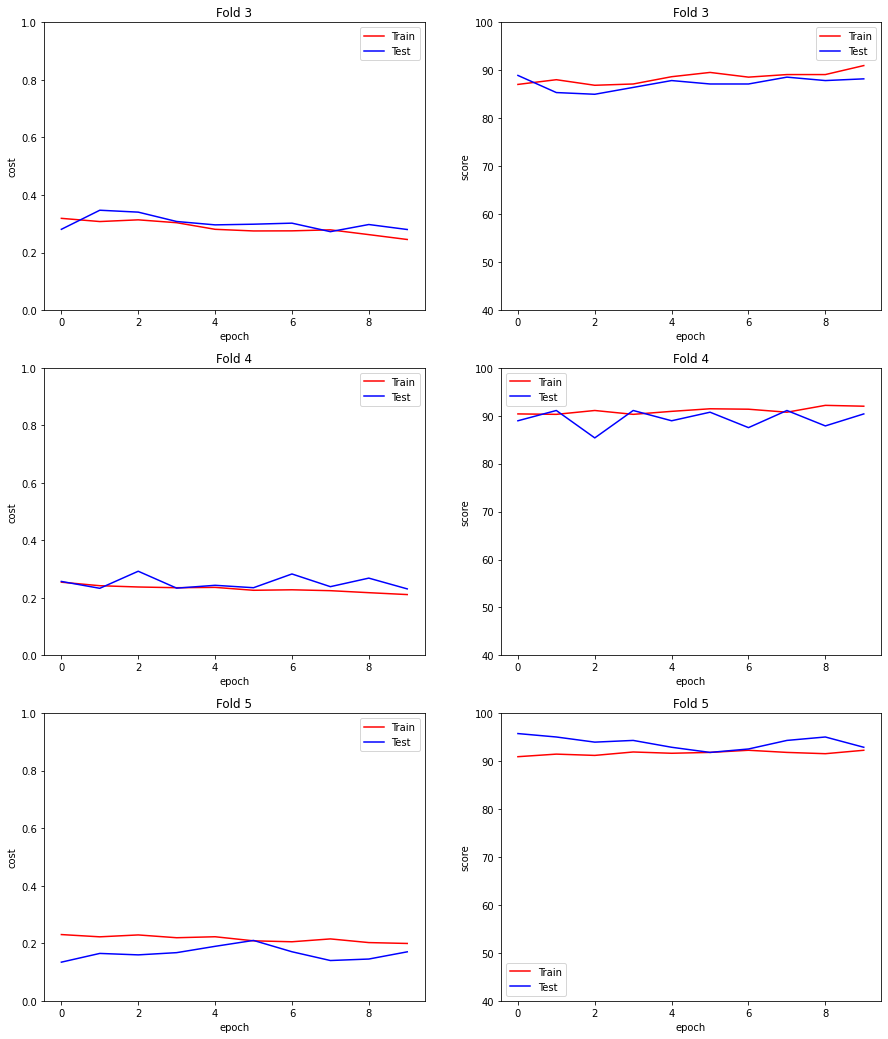

In [ ]:
plt.figure(figsize=(15,18))

plt.subplot(321)
plt.title('Fold 3')
plt.plot(trc3, 'r-', label="Train")
plt.plot(tsc3, 'b-', label="Test")
plt.xlabel("epoch"); plt.ylabel("cost"); plt.ylim((0,1)); plt.legend();

plt.subplot(322)
plt.title('Fold 3')
plt.plot(trs3, 'r-', label="Train")
plt.plot(tss3, 'b-', label="Test")
plt.xlabel("epoch"); plt.ylabel("score"); plt.ylim((40,100)); plt.legend();

plt.subplot(323)
plt.title('Fold 4')
plt.plot(trc4, 'r-', label="Train")
plt.plot(tsc4, 'b-', label="Test")
plt.xlabel("epoch"); plt.ylabel("cost"); plt.ylim((0,1)); plt.legend();

plt.subplot(324)
plt.title('Fold 4')
plt.plot(trs4, 'r-', label="Train")
plt.plot(tss4, 'b-', label="Test")
plt.xlabel("epoch"); plt.ylabel("score"); plt.ylim((40,100)); plt.legend();

plt.subplot(325)
plt.title('Fold 5')
plt.plot(trc5, 'r-', label="Train")
plt.plot(tsc5, 'b-', label="Test")
plt.xlabel("epoch"); plt.ylabel("cost"); plt.ylim((0,1)); plt.legend();

plt.subplot(326)
plt.title('Fold 5')
plt.plot(trs5, 'r-', label="Train")
plt.plot(tss5, 'b-', label="Test")
plt.xlabel("epoch"); plt.ylabel("score"); plt.ylim((40,100)); plt.legend();

##Predict

In [ ]:
feature, target = next(iter(testloader))
feature, target = feature.to(device), target.to(device)

In [ ]:
with torch.no_grad():
    model.eval()
    output = model(feature)
    preds = output.argmax(1)
preds

tensor([1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0,
        1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0,
        1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0,
        1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
        1, 1, 1, 1, 0, 0, 0, 1])

##Sanity check

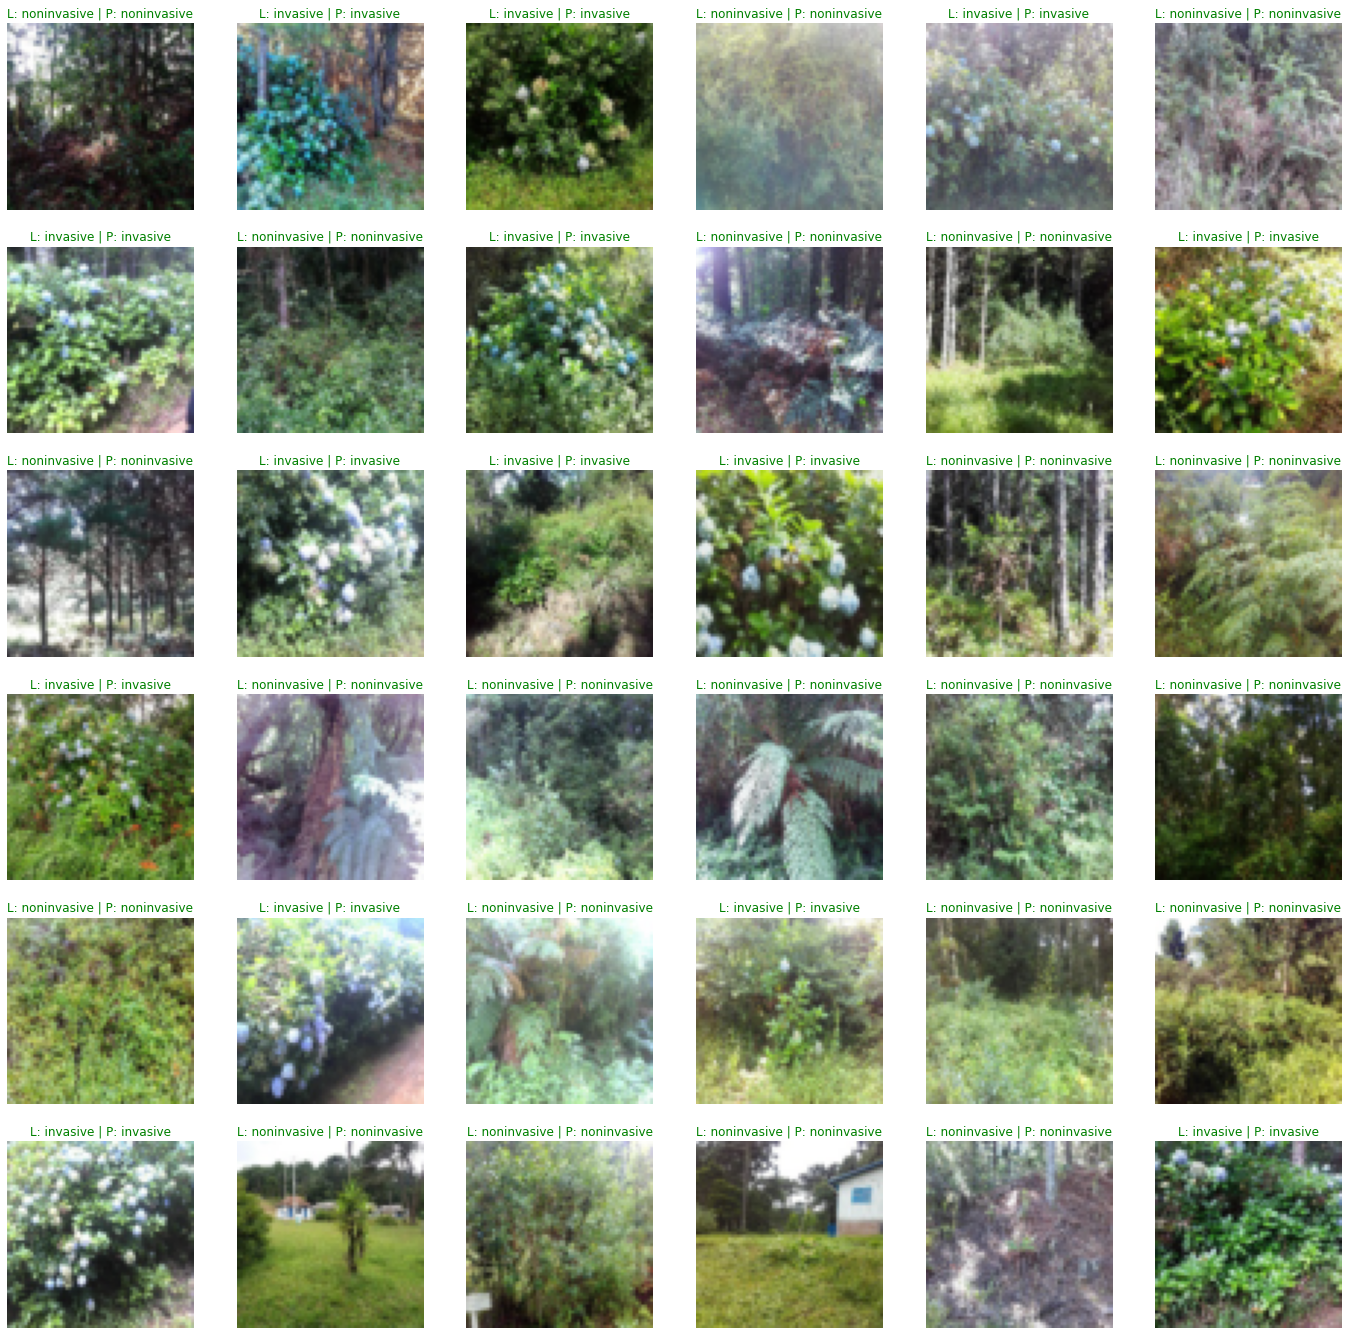

In [ ]:
fig, axes = plt.subplots(6, 6, figsize=(24,24))
for image, label, pred, ax in zip(feature, target, preds, axes.flatten()):
    ax.imshow(image.permute(1,2,0).cpu())
    font = {"color" : 'r'} if label != pred else {"color": 'g'}
    label, pred = label2cat[label.item()], label2cat[pred.item()]
    ax.set_title(f"L: {label} | P: {pred}", fontdict=font);
    ax.axis('off');